spreadsheet -> https://docs.google.com/spreadsheets/d/1lG5TFf4q5jGEF9K-_wrGlwEjfGOWxFBQQRhSt_gE_9c/edit#gid=0

In [58]:
import duckdb
import polars
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
con = duckdb.connect('md:')

In [3]:
fct_batting_season_totals = con.sql('select * from mlb.main.fct_batting_season_totals').df()

In [4]:
fct_batting_season_totals.sort_values('sb_total', ascending=False)

,mlbid,team,g_total,g_total_rank,pa_total,pa_total_rank,ab_total,ab_total_rank,r_total,r_total_rank,...,cs_total,cs_total_rank,ba_total,ba_total_rank,obp_total,obp_total_rank,slg_total,slg_total_rank,ops_total,ops_total_rank
2,660670,Atlanta,108.0,23,496.0,5,431.0,10,98.0,1,...,9.0,2,34.864,3,44.265,3,59.599,5,103.867,3
171,665923,Oakland,86.0,166,373.0,115,337.0,111,33.0,203,...,8.0,4,23.948,99,27.546,146,30.249,201,57.795,172
7,682998,Arizona,107.0,39,437.0,62,383.0,70,77.0,9,...,3.0,39,29.780,16,36.533,26,57.163,7,93.696,8
40,677951,Kansas City,110.0,7,479.0,15,447.0,5,59.0,44,...,9.0,2,27.984,32,32.484,78,48.568,31,81.051,41
41,677551,Tampa Bay,106.0,50,464.0,32,417.0,21,58.0,48,...,10.0,1,28.084,31,34.333,54,46.378,43,80.712,42
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
406,543333,Chicago,31.0,410,100.0,399,94.0,394,7.0,448,...,0.0,274,6.816,391,8.466,399,9.066,414,17.535,407
401,624503,Minnesota,34.0,396,93.0,410,91.0,401,13.0,367,...,0.0,274,6.482,400,6.649,425,11.216,391,17.867,402
400,543543,Texas,27.0,434,67.0,447,56.0,453,8.0,427,...,0.0,274,6.333,404,10.001,381,9.916,402,17.917,401
396,656308,Washington,31.0,410,67.0,447,62.0,442,10.0,404,...,0.0,274,6.666,395,7.632,409,10.500,397,18.134,397


In [5]:
fct_batting_season_totals[fct_batting_season_totals['sb_total'] > 20][['sb_total', 'team']].sort_values('sb_total')

,sb_total,team
96,21.0,Philadelphia
57,21.0,Toronto
6,22.0,Houston
138,22.0,Tampa Bay
68,23.0,Boston
15,23.0,Milwaukee
226,23.0,Arizona
194,24.0,New York
32,24.0,San Diego
108,25.0,Washington


In [ ]:
fct_batting_season_totals[fct_batting_season_totals['mlbid'] == '660670']

In [30]:
player_row = 2

In [31]:
fct_batting_season_totals.iloc[player_row]

mlbid              660670
team              Atlanta
g_total             108.0
g_total_rank           23
pa_total            496.0
pa_total_rank           5
ab_total            431.0
ab_total_rank          10
r_total              98.0
r_total_rank            1
h_total             147.0
h_total_rank            2
2b_total             27.0
2b_total_rank          13
3b_total              2.0
3b_total_rank          56
hr_total             25.0
hr_total_rank          12
rbi_total            66.0
rbi_total_rank         28
bb_total             58.0
bb_total_rank          15
ibb_total             2.0
ibb_total_rank         30
so_total             60.0
so_total_rank         215
hbp_total             5.0
hbp_total_rank         74
sh_total              0.0
sh_total_rank         164
gdp_total            10.0
gdp_total_rank         46
sb_total             51.0
sb_total_rank           1
cs_total              9.0
cs_total_rank           2
ba_total           34.864
ba_total_rank           3
obp_total   

In [105]:
total_games = 162
total_games_played = fct_batting_season_totals.iloc[player_row]['g_total']
stat = 'hr'
stat_count_goal = 40
stat_count = fct_batting_season_totals.iloc[player_row][f'{stat}_total']
stat_count_needed = stat_count_goal - stat_count
pa = fct_batting_season_totals.iloc[player_row]['pa_total']
avg_pa = pa / total_games_played
expected_pa = avg_pa * (total_games - total_games_played)
stat_per_ab = stat_count / pa
iterations = 100

In [106]:
def run_monte_carlo_sim_event(stat_per_ab, expected_pa, stat_count):
    stat = stat_count.copy()
    stat_tracker = []
    for n in range(int(expected_pa)):
        rand = np.random.random()
        if rand <= stat_per_ab:
            stat += 1
        stat_tracker.append(stat)

    return stat, stat_tracker
        

In [107]:
def iterate(iterations, expected_pa, stat_per_ab, stat_count):
    stat_list = []
    stat_tracker_list = []
    for n in range(iterations):
        stat, stat_tracker = run_monte_carlo_sim_event(stat_per_ab, expected_pa, stat_count)
        stat_list.append(stat)
        stat_tracker_list.append(stat_tracker)
    
    return stat_list, stat_tracker_list


0.31


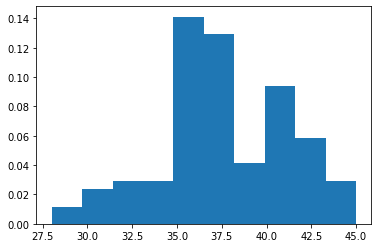

In [108]:
stat_list, stat_tracker_list = iterate(iterations, expected_pa, stat_per_ab, stat_count)
plt.hist(stat_list, bins = 10, density=True)
stat_array = np.array(stat_list)
filter_arr = stat_array >= stat_count_goal

print(sum(filter_arr)/iterations)

In [109]:
stat_tracker_list

[[26.0,
  26.0,
  26.0,
  26.0,
  26.0,
  26.0,
  26.0,
  26.0,
  26.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  27.0,
  28.0,
  28.0,
  28.0,
  28.0,
  28.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  29.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  30.0,
  31.0,
  31.0,
  31.0,
  31.0,
  31.0,


In [110]:
sim_df = pd.DataFrame()

In [97]:
i = 0
for stat_tracker in stat_tracker_list:
    i += 1
    sim_df[f'sim{i}'] = stat_tracker

In [111]:
sim_df

""


In [99]:
con.sql("create or replace table mlb.main.acuna_hr_sim_results as select *, row_number() over() as row_number from sim_df")


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [60]:
sim_df['sim1'] = stat_tracker_list[0]

In [90]:
[f'sim{i}' for i in range(1, 101)]

['sim1',
 'sim2',
 'sim3',
 'sim4',
 'sim5',
 'sim6',
 'sim7',
 'sim8',
 'sim9',
 'sim10',
 'sim11',
 'sim12',
 'sim13',
 'sim14',
 'sim15',
 'sim16',
 'sim17',
 'sim18',
 'sim19',
 'sim20',
 'sim21',
 'sim22',
 'sim23',
 'sim24',
 'sim25',
 'sim26',
 'sim27',
 'sim28',
 'sim29',
 'sim30',
 'sim31',
 'sim32',
 'sim33',
 'sim34',
 'sim35',
 'sim36',
 'sim37',
 'sim38',
 'sim39',
 'sim40',
 'sim41',
 'sim42',
 'sim43',
 'sim44',
 'sim45',
 'sim46',
 'sim47',
 'sim48',
 'sim49',
 'sim50',
 'sim51',
 'sim52',
 'sim53',
 'sim54',
 'sim55',
 'sim56',
 'sim57',
 'sim58',
 'sim59',
 'sim60',
 'sim61',
 'sim62',
 'sim63',
 'sim64',
 'sim65',
 'sim66',
 'sim67',
 'sim68',
 'sim69',
 'sim70',
 'sim71',
 'sim72',
 'sim73',
 'sim74',
 'sim75',
 'sim76',
 'sim77',
 'sim78',
 'sim79',
 'sim80',
 'sim81',
 'sim82',
 'sim83',
 'sim84',
 'sim85',
 'sim86',
 'sim87',
 'sim88',
 'sim89',
 'sim90',
 'sim91',
 'sim92',
 'sim93',
 'sim94',
 'sim95',
 'sim96',
 'sim97',
 'sim98',
 'sim99',
 'sim100']

In [61]:
sim_df

,sim1
0,25.0
1,26.0
2,26.0
3,26.0
4,26.0
...,...
243,40.0
244,40.0
245,40.0
246,40.0


In [56]:
stat_tracker_list[0]

[25.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 26.0,
 27.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 28.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 29.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 30.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 31.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 32.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,
 33.0,

In [112]:
hr_sim_results_final = pd.DataFrame(stat_array, columns=['Sim Results'])

In [113]:
con.sql('create or replace table mlb.main.acuna_hr_sim_results_final as select * from hr_sim_results_final')

In [8]:
df = fct_batting_season_totals.copy()

In [27]:
def simulate_season(df):
    # loop over 4040 stats
    for stat in ['hr', 'sb']:
        stat_prob_array = []
        # loop over dataset
        for i in range(len(fct_batting_season_totals)):
            # set/calc vars
            total_games = 162
            total_games_played = fct_batting_season_totals.iloc[i]['g_total']
            stat_count_goal = 40
            stat_count = fct_batting_season_totals.iloc[i][f'{stat}_total']
            stat_count_needed = stat_count_goal - stat_count
            pa = fct_batting_season_totals.iloc[i]['pa_total']
            avg_pa = pa / total_games_played
            # NEED TO RECALCULATE THIS FIELD. TOTAL GAMES PLAYED IS BASED ON IND. GAMES, NOT TEAM GAMES
            expected_pa = avg_pa * (total_games - total_games_played)
            stat_per_ab = stat_count / pa
            iterations = 1000
            
            # iterate over monte carlo sim
            stat_list = iterate(iterations, expected_pa, stat_per_ab)
            # convert list to array
            stat_array = np.array(stat_list)
            # filter array based on stat count needed
            filter_arr = stat_array >= stat_count_needed
            # append stat probability to list
            stat_prob_array.append(sum(filter_arr)/iterations)
        
        # add col for stat count
        df[f'40{stat}prob'] = stat_prob_array
    
    # calculate prob of reaching 40 hr and 40 sb
    df['4040prob'] = df[f'40hrprob'] * df[f'40sbprob']
             
    return df, stat_array

In [28]:
df, stat_array = simulate_season(df)

/Users/zachshirah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in double_scalars
/Users/zachshirah/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in double_scalars


In [29]:
stat_array

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [23]:
df

,mlbid,team,g_total,g_total_rank,pa_total,pa_total_rank,ab_total,ab_total_rank,r_total,r_total_rank,...,ba_total_rank,obp_total,obp_total_rank,slg_total,slg_total_rank,ops_total,ops_total_rank,40hrprob,40sbprob,4040prob
0,660271,Los Angeles,110.0,7,493.0,7,411.0,30,85.0,5,...,4,43.825,5,75.392,1,119.218,1,1.000,0.0,0.000
1,518692,Los Angeles,109.0,16,500.0,2,436.0,7,95.0,2,...,2,44.867,2,62.201,4,107.067,2,0.029,0.0,0.000
2,660670,Atlanta,108.0,23,496.0,5,431.0,10,98.0,1,...,3,44.265,3,59.599,5,103.867,3,0.291,1.0,0.291
3,605141,Los Angeles,104.0,62,482.0,13,406.0,39,89.0,4,...,10,39.932,9,62.632,3,102.565,4,0.922,0.0,0.000
4,621566,Atlanta,108.0,23,482.0,13,409.0,34,83.0,6,...,47,38.633,12,62.920,2,101.553,5,1.000,0.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,571946,Los Angeles,1.0,624,1.0,626,1.0,625,0.0,591,...,604,0.000,613,0.000,604,0.000,613,0.000,0.0,0.000
635,660636,Arizona,1.0,624,1.0,626,1.0,625,0.0,591,...,604,0.000,613,0.000,604,0.000,613,0.000,0.0,0.000
636,669256,Detroit,1.0,624,0.0,633,0.0,633,0.0,591,...,604,0.000,613,0.000,604,0.000,613,0.000,0.0,0.000
637,664314,New York,1.0,624,0.0,633,0.0,633,0.0,591,...,604,0.000,613,0.000,604,0.000,613,0.000,0.0,0.000


In [24]:
df[df['mlbid'] == '660670']

,mlbid,team,g_total,g_total_rank,pa_total,pa_total_rank,ab_total,ab_total_rank,r_total,r_total_rank,...,ba_total_rank,obp_total,obp_total_rank,slg_total,slg_total_rank,ops_total,ops_total_rank,40hrprob,40sbprob,4040prob
2,660670,Atlanta,108.0,23,496.0,5,431.0,10,98.0,1,...,3,44.265,3,59.599,5,103.867,3,0.291,1.0,0.291


In [25]:
df.sort_values(['4040prob', '40hrprob', '40sbprob'], ascending=False).head(15)

,mlbid,team,g_total,g_total_rank,pa_total,pa_total_rank,ab_total,ab_total_rank,r_total,r_total_rank,...,ba_total_rank,obp_total,obp_total_rank,slg_total,slg_total_rank,ops_total,ops_total_rank,40hrprob,40sbprob,4040prob
421,680869,Oakland,18.0,478,76.0,431,69.0,431,12.0,374,...,453,5.383,455,9.133,412,14.517,422,0.808,0.803,0.648824
2,660670,Atlanta,108.0,23,496.0,5,431.0,10,98.0,1,...,3,44.265,3,59.599,5,103.867,3,0.291,1.000,0.291000
294,665862,Miami,50.0,331,200.0,296,182.0,293,23.0,282,...,296,15.634,307,22.500,282,38.133,295,0.070,0.945,0.066150
307,514888,Houston,41.0,372,182.0,314,156.0,318,33.0,203,...,318,14.902,319,19.911,305,34.813,308,0.055,0.228,0.012540
7,682998,Arizona,107.0,39,437.0,62,383.0,70,77.0,9,...,16,36.533,26,57.163,7,93.696,8,0.010,1.000,0.010000
292,682829,Cincinnati,51.0,329,226.0,275,209.0,269,41.0,156,...,298,15.433,311,22.916,279,38.350,293,0.010,0.995,0.009950
80,641355,Chicago,80.0,196,340.0,146,304.0,142,62.0,31,...,72,29.316,118,43.365,68,72.684,81,0.054,0.039,0.002106
40,677951,Kansas City,110.0,7,479.0,15,447.0,5,59.0,44,...,32,32.484,78,48.568,31,81.051,41,0.002,0.986,0.001972
77,665487,San Diego,91.0,136,419.0,76,382.0,71,62.0,31,...,93,29.033,126,43.810,64,72.843,78,0.076,0.006,0.000456
443,687799,Seattle,13.0,506,38.0,494,32.0,499,6.0,455,...,459,5.166,463,6.667,437,11.833,444,0.004,0.001,0.000004


In [26]:
con.sql('create or replace table mlb.main.fct_batting_season_totals_v2 as select * from df')